In [31]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import cPickle as pickle
from spiketopics.helpers import *

%matplotlib inline
sns.set_style('darkgrid')
savefigs = False

# Load in data

In [32]:
infile = 'data/fitted_model_object.pkl'
gpm = pickle.load(open(infile, 'rb'))
dt = 0.020

In [33]:
gpm.Nframe.head()

,unit,time,count,lam0,lam1
0,2,364,1,-0.916307,-0.925421
1,8,364,1,-1.034085,-1.052426
2,0,364,0,-0.387339,-0.305787
3,0,364,1,-0.451895,-0.594661
4,0,364,0,-0.387339,-0.305787


In [34]:
if gpm.regressors:
    gpm.Xframe.head()

# Plot inferred categories as matrix

In [35]:
xi = gpm.nodes['HMM'].nodes['z'].z[1].copy()
T, K = xi.shape
print xi.shape

(624, 10)


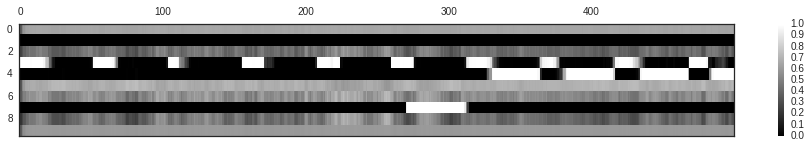

In [36]:
matshow(xi[:500].T, vmin=0, vmax=1);
plt.colorbar();

## Make $\xi$ dataframe:

In [37]:
xif = pd.DataFrame(xi)
xif.columns = ['Z' + str(k) for k in range(K)]
xif.index.name = 'time'
xif = xif.reset_index()

# Posteriors for effects

## Baselines

In [38]:
bl = gpm.nodes['baseline']
unit_baseline_means = bl.expected_x() / dt

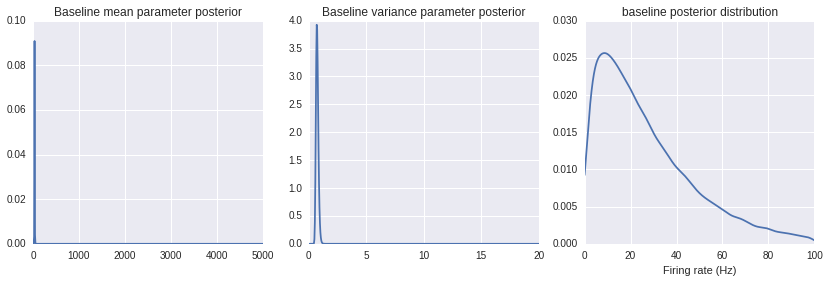

In [39]:
plt.figure(figsize=(14, 4))

th = gpm.nodes['baseline_mean']
cc = gpm.nodes['baseline_shape']
th_pars = [th.post_shape, th.post_rate]
cc_pars = [cc.post_shape, cc.post_rate]
samples = gamma_from_hypers(th_pars, cc_pars, 1e5)

plt.subplot(1, 3, 1)
xx = np.linspace(0, 5000, 500)
plt.plot(xx, stats.invgamma.pdf(xx, a=th_pars[0], scale=th_pars[1]/dt))
plt.title('Baseline mean parameter posterior');

plt.subplot(1, 3, 2)
xx = np.linspace(0, 20, 500)
plt.plot(xx, stats.invgamma.pdf(xx, a=cc_pars[0], scale=cc_pars[1]))
plt.title('Baseline variance parameter posterior');

plt.subplot(1, 3, 3)
sns.kdeplot(samples / dt, gridsize=1e4, clip=(0, 100))
plt.title('baseline posterior distribution')
plt.xlabel('Firing rate (Hz)')
plt.xlim(0, 100);

## Regressors

In [40]:
if gpm.regressors:
    plt.figure(figsize=(8, 6));
    inferred_means = gpm.nodes['fr_regressors'].expected_x()
    R = inferred_means.shape[1]
    for r in xrange(R):
        plt.hist(inferred_means[:, r], bins=50, normed=True, alpha=0.25, label='X' + str(r))
    plt.title('Regression effects');
    plt.legend()
    plt.ylim(0, 5);
    plt.xlim(0, 5);

## Latent Categories

In [41]:
frn = gpm.nodes['fr_latents']
fr_mean_effect = frn.expected_x()

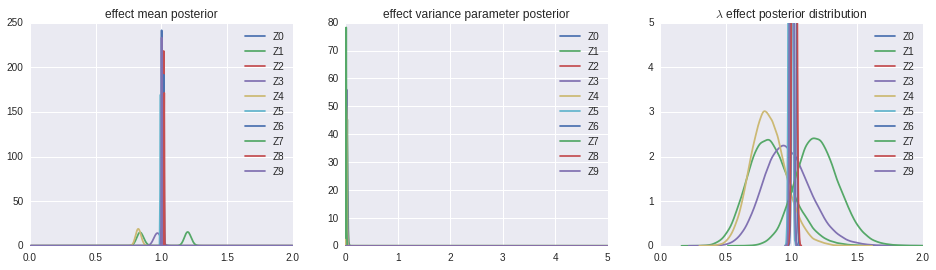

In [42]:
plt.figure(figsize=(16, 4))

th = gpm.nodes['fr_latents_mean']
cc = gpm.nodes['fr_latents_shape']

th_pars = np.c_[th.post_shape, th.post_rate].T
cc_pars = np.c_[cc.post_shape, cc.post_rate].T

plt.subplot(1, 3, 1)
xx = np.linspace(0, 2, 500)
for kk in xrange(K):
    plt.plot(xx, stats.invgamma.pdf(xx, a=th_pars[0, kk], scale=th_pars[1, kk]), label='Z' + str(kk))
plt.legend()
plt.title('effect mean posterior');

plt.subplot(1, 3, 2)
xx = np.linspace(0, 5, 500)
for kk in xrange(K):
    plt.plot(xx, stats.invgamma.pdf(xx, a=cc_pars[0, kk], scale=cc_pars[1, kk]), label='Z' + str(kk))
plt.legend()
plt.title('effect variance parameter posterior');

plt.subplot(1, 3, 3)
for kk in xrange(K):
    samples = gamma_from_hypers(th_pars[:, kk], cc_pars[:, kk], 1e5)
    sns.kdeplot(samples, gridsize=1e4, clip=(0, 10), label='Z' + str(kk))
plt.legend()
plt.title(r'$\lambda$ effect posterior distribution')
plt.xlim(0, 2);
plt.ylim(0, 5);

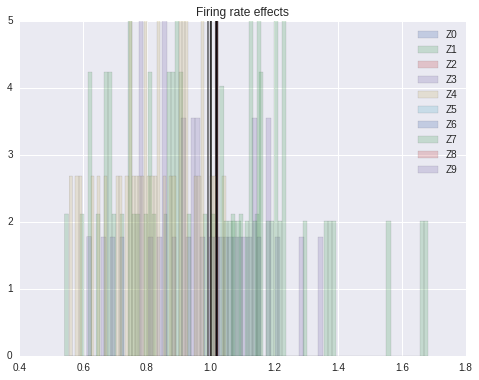

In [43]:
plt.figure(figsize=(8, 6))

inferred_effects = gpm.nodes['fr_latents'].expected_x()
for kk in xrange(K):
    plt.hist(inferred_effects[..., kk], bins=50, normed=True, alpha=0.25, label='Z' + str(kk));
plt.legend();
plt.title('Firing rate effects');
plt.ylim(0, 5);

## Overdispersion

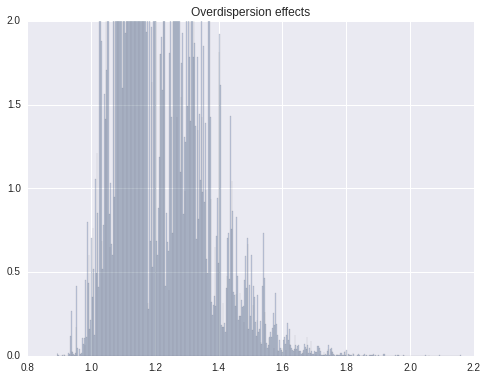

In [44]:
if gpm.overdispersion:
    plt.figure(figsize=(8, 6))

    inferred_means = gpm.nodes['overdispersion'].expected_x().ravel()
    plt.hist(inferred_means, bins=500, normed=True, alpha=0.25);
    plt.title('Overdispersion effects');
    plt.ylim(0, 2);

# Load and prepare coded features:

Our goal here is to load the ethogram, join it to the inferred ethogram, and perform some comparisons to see if any of our discovered categories match hand-labeled categories from the ethogram.

In [45]:
codefile = 'data/roitman_fd_data.csv'
code = pd.read_csv(codefile).groupby('utime').mean().reset_index()

In [46]:
code.head()

,utime,count,time,trial,stimulus,coherence,fixation_on,fixation,target_on,stim_on,...,Xstim,Xcoh0,Xcoh32,Xcoh64,Xcoh128,Xcoh256,Xcoh512,Xin,Xout,into_RF
0,0,0.595890,0,32.89726,71,0,0,52.547945,460.438356,903.780822,...,0,0,0,0,0,0,0,0,0,1
1,1,0.780822,20,32.89726,71,0,0,52.547945,460.438356,903.780822,...,1,1,0,0,0,0,0,1,0,1
2,2,0.636986,40,32.89726,71,0,0,52.547945,460.438356,903.780822,...,1,1,0,0,0,0,0,1,0,1
3,3,0.746575,60,32.89726,71,0,0,52.547945,460.438356,903.780822,...,1,1,0,0,0,0,0,1,0,1
4,4,0.623288,80,32.89726,71,0,0,52.547945,460.438356,903.780822,...,1,1,0,0,0,0,0,1,0,1


In [47]:
# convert bools to floats
for col in code:
    code[col] = code[col].astype('float')

In [48]:
# merge labeled and inferred etho on movie and frame columns
edf = pd.merge(code, xif, how='right', left_on='utime', right_on='time')
edf.columns

Index([u'utime', u'count', u'time_x', u'trial', u'stimulus', u'coherence', u'fixation_on', u'fixation', u'target_on', u'stim_on', u'stim_off', u'fixation_off', u'saccade', u'reward', u'choice', u'correct', u'unit', u'Xstim', u'Xcoh0', u'Xcoh32', u'Xcoh64', u'Xcoh128', u'Xcoh256', u'Xcoh512', u'Xin', u'Xout', u'into_RF', u'time_y', u'Z0', u'Z1', u'Z2', u'Z3', u'Z4', u'Z5', u'Z6', u'Z7', u'Z8', u'Z9'], dtype='object')

In [49]:
# get rid of categories that are either identifiers or have non-binary entries
to_drop = [col for col in edf.columns if not ('Z' in col or 'X' in col)]
edf = edf.drop(to_drop, axis=1)

In [50]:
edf.head()

,Xstim,Xcoh0,Xcoh32,Xcoh64,Xcoh128,Xcoh256,Xcoh512,Xin,Xout,Z0,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9
0,0,0,0,0,0,0,0,0,0,0.036040,0.000732,0.029142,0.962952,0.000196,0.039785,0.028880,0.000014,0.027503,0.036326
1,1,1,0,0,0,0,0,1,0,0.370518,0.000006,0.263811,0.996810,0.000019,0.340622,0.358498,0.000010,0.208163,0.360883
2,1,1,0,0,0,0,0,1,0,0.520177,0.000062,0.322977,0.999520,0.000216,0.520051,0.435894,0.000001,0.273015,0.496841
3,1,1,0,0,0,0,0,1,0,0.588826,0.000000,0.380312,0.999991,0.000008,0.597171,0.506714,0.000004,0.339161,0.555564
4,1,1,0,0,0,0,0,1,0,0.619607,0.000016,0.376092,0.999849,0.000134,0.649948,0.498190,0.000001,0.354928,0.579804


# Compare actual and predicted firing

In [51]:
# make dataframe of firing rates
meancnt = code.groupby(['time', 'stimulus']).mean()['count'].unstack(level=1)
fr = pd.rolling_mean(meancnt, 9, min_periods=1, center=True) / dt

In [52]:
# calculate predicted firing rate
pred_mat = unit_baseline_means[np.newaxis, :] * np.exp(xi.dot(np.log(fr_mean_effect.T)))
preds = np.mean(pred_mat, axis=1)  # mean across units
code['pred_fr'] = preds * np.mean(gpm.nodes['overdispersion'].expected_x())

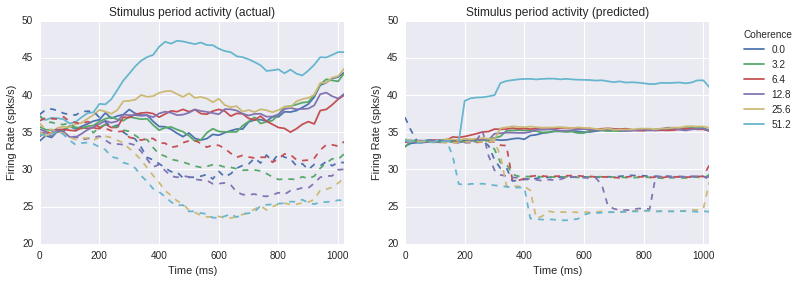

In [53]:
if savefigs:
    sns.set_context('talk', font_scale=1)
    sns.set_style('white')

plt.figure(figsize=(12, 4))

##### first, do actual
ax = plt.subplot(1, 2, 1)

# label cols according to coherence, RF
coh_tbl = code[['stimulus', 'coherence', 'into_RF']].drop_duplicates()
colnames = []
for idx, row in coh_tbl.iterrows():
    coh_str = str(row['coherence'] / 10)
    colnames.append(coh_str)

fr.columns = colnames
midpt = int(fr.shape[1] / 2)
fr.iloc[:, :midpt].plot(ax=ax, legend=False)
fr.iloc[:, midpt:].plot(ax=ax, legend=False, linestyle='--')
plt.xlabel('Time (ms)')
plt.ylabel('Firing Rate (spks/s)')
plt.title('Stimulus period activity (actual)')
yl = plt.ylim()

##### now do predicted
ax = plt.subplot(1, 2, 2)

# data frame of predicted firing for each stimulus
pred_df = code.groupby(['time', 'stimulus']).mean()['pred_fr'].unstack(level=1)

# plot
midpt = int(pred_df.shape[1] / 2)
pred_df.iloc[:, :midpt].plot(ax=ax, legend=False)
pred_df.iloc[:, midpt:].plot(ax=ax, legend=False, linestyle='--')
plt.ylim(yl)
ax.legend(colnames[:midpt], bbox_to_anchor=(1.3, 1.00), title='Coherence');
plt.xlabel('Time (ms)')
plt.ylabel('Firing Rate (spks/s)')
plt.title('Stimulus period activity (predicted)');

if savefigs:
    plt.savefig('roitman_fr.svg')
    sns.set()
    sns.set_style('darkgrid')

# View results:

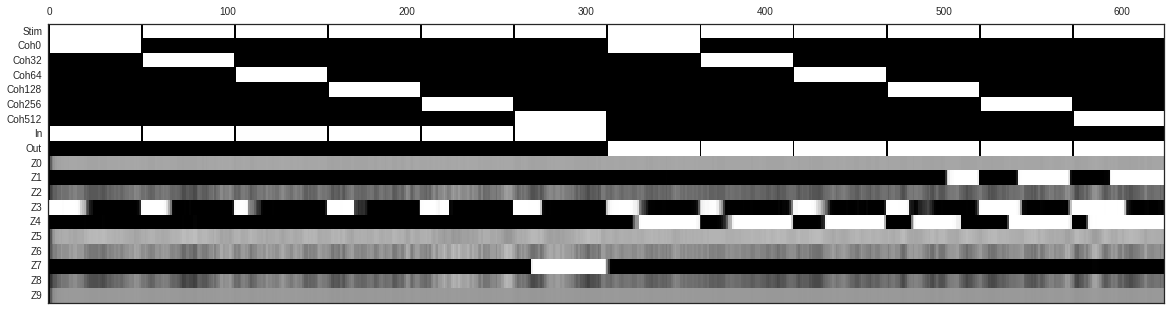

In [54]:
if savefigs:
    sns.set_context('poster', font_scale=1)

# plot a section in time; each row is a regressor; bottom rows are inferred categories
trng = slice(None)
matshow(edf.iloc[trng].values.T, vmin=0, vmax=1);
col_labels = [c.replace('X', '').capitalize() for c in edf.columns]
plt.yticks(xrange(len(col_labels)), col_labels);
plt.gcf().set_size_inches([20, 5])

if savefigs:
    plt.savefig('roitman_recovery.svg')
    sns.set()

## Overlap analysis:

Define the overlap as the maximum of the match or mismatch percentage. That is, if $x$ and $y$ are binary vectors, 
$$
\mathrm{overlap} = \max \{ \mathbb{E}[xy + (1-x)(1-y)], \mathbb{E}[(1-x)y + x(1-y)]\}
$$

In [55]:
match = (edf.T.dot(edf) + (1 - edf.T).dot(1 - edf)) / T
mismatch = (edf.T.dot(1 - edf) + (1 - edf.T).dot(edf)) / T
overlap = np.maximum(match, mismatch)

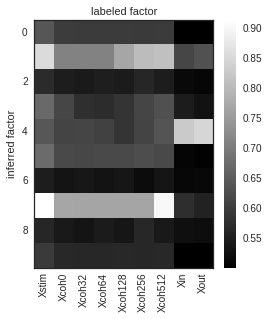

In [56]:
row_labels = edf.columns[:-K]
matshow(overlap.values[-K:,:-K]) #, vmin=0.5, vmax=1)
plt.ylabel('inferred factor')
plt.xlabel('labeled factor')
plt.colorbar();

# add column names
ax = plt.gca()
ax.xaxis.set_label_position('top')
plt.tick_params(axis='x', which='both', top='off', bottom='off', 
                labelbottom='on', labeltop='off', pad=5)
plt.xticks(xrange(len(row_labels)), row_labels, rotation='vertical', horizontalalignment='center');

In [57]:
overlap.iloc[-K:, :]

,Xstim,Xcoh0,Xcoh32,Xcoh64,Xcoh128,Xcoh256,Xcoh512,Xin,Xout,Z0,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9
Z0,0.641100,0.598057,0.596901,0.596319,0.597650,0.596061,0.597713,0.501863,0.502053,0.543450,0.608348,0.520031,0.547296,0.545648,0.553495,0.516187,0.625068,0.517353,0.529681
Z1,0.855931,0.711741,0.711750,0.711700,0.768939,0.804718,0.811015,0.614779,0.634871,0.608348,0.996962,0.554289,0.565760,0.753650,0.633413,0.539305,0.806810,0.546674,0.573045
Z2,0.570476,0.549089,0.543765,0.550391,0.546125,0.562712,0.548242,0.516043,0.512230,0.520031,0.554289,0.518703,0.517079,0.520324,0.528720,0.500656,0.563617,0.520752,0.513246
Z3,0.670438,0.614033,0.576895,0.574007,0.585239,0.613702,0.630984,0.547437,0.530466,0.547296,0.565760,0.517079,0.952902,0.567039,0.556884,0.520717,0.605517,0.512153,0.532380
Z4,0.642953,0.612183,0.613585,0.606969,0.584987,0.610763,0.636618,0.828081,0.846998,0.545648,0.753650,0.520324,0.567039,0.986528,0.553879,0.519886,0.593409,0.513611,0.530532
Z5,0.675105,0.621598,0.616437,0.619183,0.619432,0.626318,0.620696,0.510677,0.505708,0.553495,0.633413,0.528720,0.556884,0.553879,0.567865,0.516124,0.655212,0.527149,0.536465
Z6,0.549192,0.534556,0.539723,0.533034,0.536755,0.521334,0.535196,0.513915,0.514767,0.516187,0.539305,0.500656,0.520717,0.519886,0.516124,0.513519,0.543299,0.504730,0.511270
Z7,0.914012,0.769015,0.768178,0.768175,0.768176,0.768194,0.902396,0.575800,0.557319,0.625068,0.806810,0.563617,0.605517,0.593409,0.655212,0.543299,0.997882,0.556638,0.584408
Z8,0.562856,0.542624,0.533682,0.545143,0.537962,0.565466,0.542295,0.525480,0.522215,0.517353,0.546674,0.520752,0.512153,0.513611,0.527149,0.504730,0.556638,0.524887,0.511401
Z9,0.595715,0.566269,0.565325,0.564910,0.565815,0.564685,0.565875,0.501116,0.501062,0.529681,0.573045,0.513246,0.532380,0.530532,0.536465,0.511270,0.584408,0.511401,0.520356


## Mutual Information

In [58]:
mi_mat = mutual_information_matrix(edf.iloc[:, :-K].values, edf.iloc[:, -K:].values)

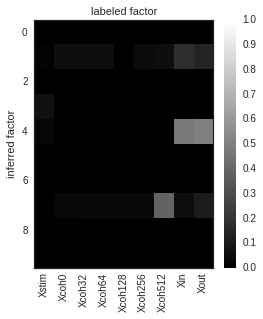

In [59]:
row_labels = edf.columns[:-K]
matshow(mi_mat.T, vmin=0, vmax=1)
plt.ylabel('inferred factor')
plt.xlabel('labeled factor')
plt.colorbar();

# add column names
ax = plt.gca()
ax.xaxis.set_label_position('top')
plt.tick_params(axis='x', which='both', top='off', bottom='off', 
                labelbottom='on', labeltop='off', pad=5)
plt.xticks(xrange(len(row_labels)), row_labels, rotation='vertical', horizontalalignment='center');

In [60]:
pd.DataFrame(mi_mat.T, columns=row_labels)

,Xstim,Xcoh0,Xcoh32,Xcoh64,Xcoh128,Xcoh256,Xcoh512,Xin,Xout
0,0.000416,0.000003,0.000002,0.000009,3.442175e-07,0.000014,5.748840e-07,-0.000406,-0.000004
1,0.013632,0.058081,0.058001,0.058478,5.093758e-03,0.045883,5.678009e-02,0.180684,0.147256
2,0.000074,0.000005,0.000257,0.000002,9.765888e-05,0.001105,1.901363e-05,0.000981,0.000104
3,0.066073,0.000902,0.005317,0.006588,2.432729e-03,0.000849,5.735541e-03,-0.003963,-0.000505
4,0.027316,0.000088,0.000176,0.000025,4.474191e-03,0.000030,5.768177e-03,0.469719,0.502638
5,0.000622,0.000003,0.000166,0.000026,1.927868e-05,0.000224,6.794967e-07,-0.000211,-0.000335
6,0.000139,0.000006,0.000248,0.000002,6.526717e-05,0.001013,1.644855e-05,0.000294,0.000738
7,0.000800,0.032300,0.037915,0.037954,3.794877e-02,0.037738,3.879739e-01,0.053193,0.107571
8,0.000040,0.000022,0.000782,0.000003,2.826019e-04,0.002963,3.065723e-05,0.002166,0.000885
9,0.000332,0.000002,0.000001,0.000005,1.260845e-08,0.000008,7.381198e-08,-0.000190,0.000002
